In [1]:
import math
import nltk
import scipy
import string
import re
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from scipy.stats import randint
from wordcloud import WordCloud
from multiprocessing import Pool
from nltk.corpus import stopwords
from scipy.stats import loguniform

from sklearn.decomposition import PCA
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV,RepeatedStratifiedKFold,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import lightgbm as lgb
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score,roc_auc_score, roc_curve, precision_score, recall_score
# from scikitplot.metrics import plot_roc_curve as auc_roc
import matplotlib.pyplot as plt
from IPython.display import display
plt.rcParams['figure.figsize'] = [20,6]
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import warnings 
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('Tweets.csv', header=0)

In [3]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
df.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,414fad1ccd,Oh..I`m so borin`.. why not play the computer?...,good,neutral
freq,1,1,199,11118


In [5]:
df.drop(['selected_text', 'textID'], axis=1, inplace=True)

In [6]:
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [7]:
df.shape

(27481, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


In [9]:
df.dropna(inplace=True)
second_df = df.copy(deep=True)
second_df

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27476,wish we could come see u on Denver husband l...,negative
27477,I`ve wondered about rake to. The client has ...,negative
27478,Yay good for both of you. Enjoy the break - y...,positive
27479,But it was worth it ****.,positive


In [10]:
df[df.duplicated()]

,text,sentiment


In [11]:
counter = 0
r,c = second_df.shape

df_nodup = df.drop_duplicates()
df_nodup.reset_index(drop=True, inplace=True)

In [12]:
df_nodup.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [13]:
df_filter = df_nodup.copy()

def preprocessor(text):
    #text = re.sub('[http:,https:]','',text)
    text = re.sub('[^a-zA-Z]',' ',text)
    text = text.lower()
    text = text.strip()
    text = ''.join([i for i in text if i in string.ascii_lowercase+' '])
    text = ' '.join([word for word in text.split() if word.isalnum()])
    text = ' '.join([WordNetLemmatizer().lemmatize(word,pos='v') for word in text.split()])    
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

In [14]:
df_filter['text'] = df_nodup['text'].apply(preprocessor)

df_filter.head()

,text,sentiment
0,respond go,neutral
1,sooo sad miss san diego,negative
2,boss bully,negative
3,interview leave alone,negative
4,sons put release already buy,negative


In [15]:
porter=PorterStemmer()
target = 'sentiment'
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [52]:
df_vector=TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None,tokenizer=tokenizer_porter,use_idf=True,norm='l2',smooth_idf=True)
label=df_filter[target].values
features=df_vector.fit_transform(df_filter.text)
features

<27480x19389 sparse matrix of type '<class 'numpy.float64'>'
	with 191163 stored elements in Compressed Sparse Row format>

In [17]:
print(label)
print(features)

['neutral' 'negative' 'negative' ... 'positive' 'positive' 'neutral']
  (0, 6637)	0.3776400355368082
  (0, 13899)	0.9259524845043391
  (1, 4349)	0.5774904410682079
  (1, 14380)	0.5374236061146065
  (1, 10732)	0.28866086704873706
  (1, 14309)	0.33255522986570935
  (1, 15440)	0.4286753794997508
  (2, 2290)	0.7669109047171836
  (2, 1982)	0.6417535852847812
  (3, 468)	0.5878637688905023
  (3, 9454)	0.45003602763553296
  (3, 8255)	0.6722230009869373
  (4, 2379)	0.3991796814525973
  (4, 478)	0.389645210134384
  (4, 13790)	0.522200391827341
  (4, 13339)	0.41179156328860056
  (4, 15421)	0.4965547817858938
  (5, 4870)	0.2954023249782883
  (5, 6036)	0.31519803969485477
  (5, 13549)	0.34631673286147474
  (5, 1576)	0.20131738013490516
  (5, 12868)	0.31519803969485477
  (5, 14747)	0.3866654464821108
  (5, 15259)	0.3866654464821108
  (5, 3307)	0.1629500188088339
  :	:
  (27476, 280)	0.34339318025545407
  (27476, 9448)	0.22763852799456433
  (27476, 6000)	0.2728516815929536
  (27476, 18708)	0.20526189

               Sentiment Distibution               


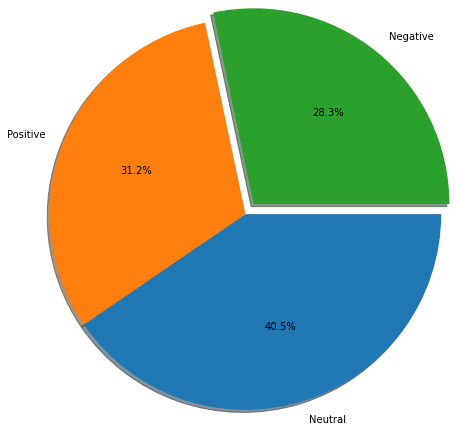

In [18]:
print('\033[1mSentiment Distibution'.center(55))

plt.pie(df_filter[target].value_counts(), labels=['Neutral','Positive','Negative'], counterclock=False, shadow=True, 
        explode=[0,0,0.1], autopct='%1.1f%%', radius=1.5, startangle=0)
plt.show()

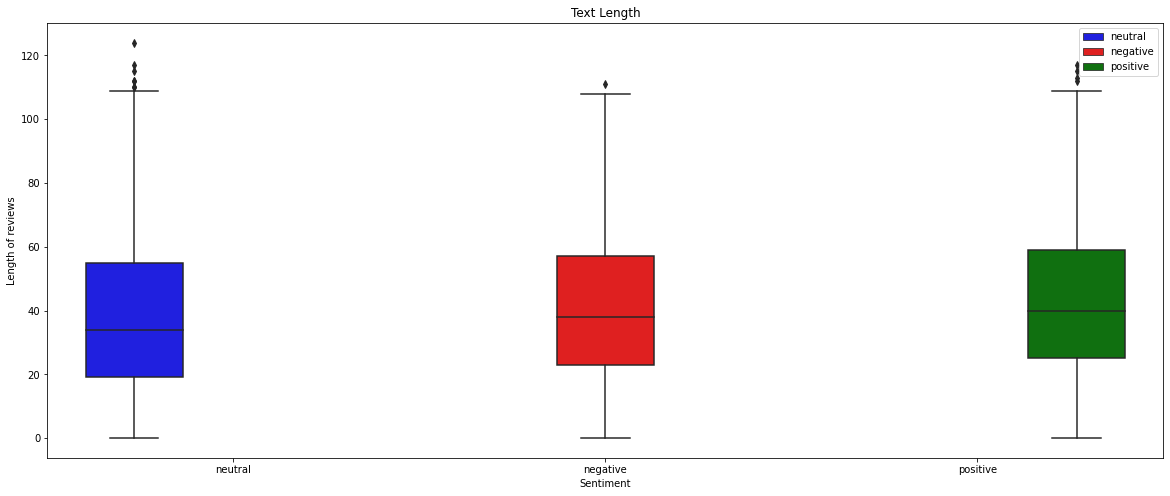

In [19]:
df_rl = df_filter.copy()
df_rl['review_length'] = 0


df_rl['review_length'] = df_rl['text'].apply(lambda x: len(x))

plt.figure(figsize=[20,8])
sns.boxplot(x=label,y='review_length', data=df_rl, hue=label,palette=['blue','red','green'])
plt.title('Text Length')
plt.xlabel("Sentiment")
plt.ylabel("Length of reviews")
plt.show()

In [20]:
neut_df = second_df[second_df[target]=='neutral']['text']
pos_df = second_df[second_df[target]=='positive']['text']

neg_df = second_df[second_df[target]== 'negative']['text']

In [21]:
def freq_text(text_df):     # returns all occurences of words in text_df
 
    combi_text=""
    for x in text_df.values:
        combi_text+=' '.join(x.split())
    combi_text  = [x for x in combi_text.split() if len(x) >3 and x not in stopwords.words('english')]  
    return combi_text

In [22]:
def freq_df(text_count_df,senti):    # returns the count of each word in text_count_df obtained from previous function
    fredis = nltk.FreqDist(neut_text)
    fredis_df = pd.DataFrame({senti: list(fredis.keys()),
                      'Count': list(fredis.values())})
    fredis_df = fredis_df.sort_values(by='Count',ascending=False)
    return fredis_df

In [23]:
def plot_freq_dis(text_count_df,senti):  # plots freq_df
    sns.barplot(data=text_count_df[:10],x=senti,y='Count')

In [24]:
neut_df = neut_df.apply(preprocessor)

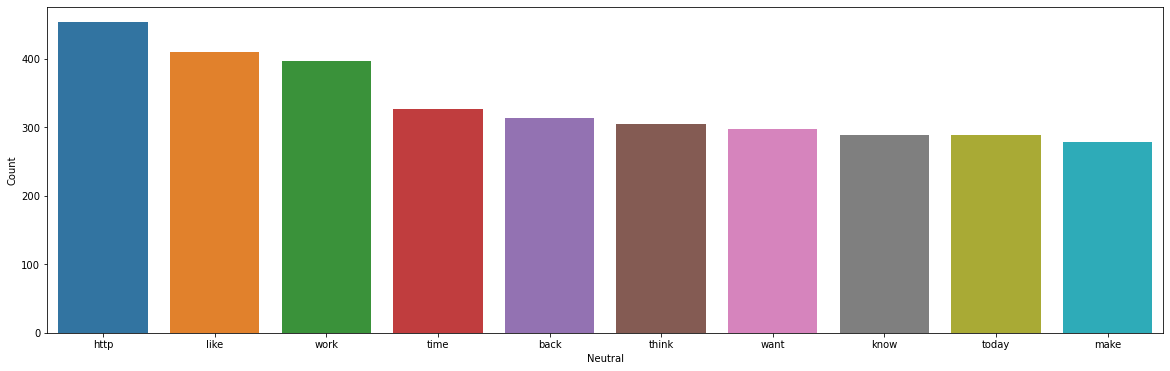

In [25]:
sen = 'Neutral'
neut_text = freq_text(neut_df)
neut_freq_df = freq_df(neut_text,sen)
plot_freq_dis(neut_freq_df,sen)

In [26]:
pos_df = pos_df.apply(preprocessor)
pos_df

6                                  feed baby fun smile coo
9                journey wow u become cooler hehe possible
11         really really like song love story taylor swift
21       play ghost online really interest new update k...
25                      free fillin app ipod fun im addict
                               ...                        
27467           morning twit friends welcome new followers
27474    get early feel good day walk work feel alright...
27475                                       enjoy ur night
27478    yay good enjoy break probably need hectic week...
27479                                                worth
Name: text, Length: 8582, dtype: object

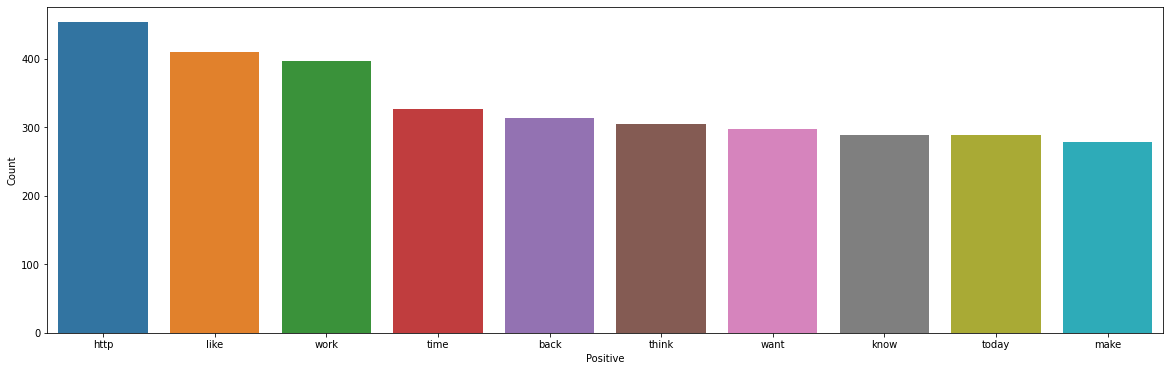

In [27]:
sen ='Positive'
pos_text = freq_text(pos_df)
pos_freq_df = freq_df(pos_text,sen)
plot_freq_dis(pos_freq_df,sen)

In [28]:
neg_df = neg_df.apply(preprocessor)
neg_df

1                                  sooo sad miss san diego
2                                               boss bully
3                                    interview leave alone
4                             sons put release already buy
12                         sharpie run dangerously low ink
                               ...                        
27464    rec game try cry pain much need lose heart bre...
27470      lol know haha fall asleep get bore shaun p joke
27472          http twitpic com vr want visit animals late
27476    wish could come see u denver husband lose job ...
27477    wonder rake client make clear net force devs l...
Name: text, Length: 7781, dtype: object

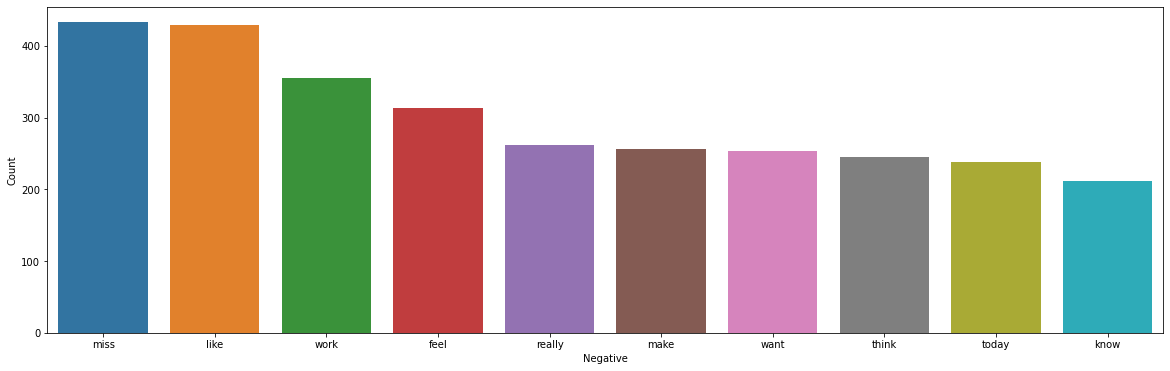

In [29]:
sen ='Negative'
neut_text = freq_text(neg_df)
neut_frq_df = freq_df(neut_text,sen)
plot_freq_dis(neut_frq_df,sen)

In [30]:
label_mapping={'negative':0, 'neutral':1, 'positive':2}
df_filter['sentiment'] = df_filter['sentiment'].map(label_mapping)

In [47]:
X = features
y = pd.Series(label).map(label_mapping)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)
print(X_test)

  (0, 5396)	0.582806048713555
  (0, 18293)	0.5587496367956399
  (0, 11457)	0.4675546598243718
  (0, 9884)	0.35990081000207486
  (1, 16103)	0.40916598060395243
  (1, 6119)	0.33051057019303126
  (1, 3268)	0.25268860961950323
  (1, 6156)	0.3531307356173499
  (1, 3584)	0.21169686119516212
  (1, 11887)	0.26108157651061303
  (1, 18197)	0.2894461615207789
  (1, 18293)	0.24868326763634208
  (1, 11432)	0.21576376376401274
  (1, 4602)	0.21904610184184092
  (1, 3847)	0.25620568648497993
  (1, 10703)	0.2614285390274776
  (1, 11952)	0.1737136648565947
  (1, 6482)	0.13226354801884632
  (2, 7666)	0.5962674558971939
  (2, 3441)	0.5749406784651558
  (2, 18717)	0.5602752335093121
  (3, 7602)	0.5201293555511123
  (3, 15405)	0.4232813790306593
  (3, 16603)	0.308825753352374
  (3, 9146)	0.3057515355244789
  :	:
  (5492, 3268)	0.7077576679162174
  (5492, 15757)	0.6015312836965574
  (5492, 6482)	0.3704580924209501
  (5493, 10747)	0.351157141058909
  (5493, 13160)	0.3444962206050434
  (5493, 13432)	0.26777277

In [39]:
RF_model = RandomForestClassifier()
RF_model.fit(X_train, y_train)
pred = RF_model.predict(X_test)
pred_prob = RF_model.predict_proba(X_test)
pred_prob

array([[0.07      , 0.11533333, 0.81466667],
       [0.15      , 0.16      , 0.69      ],
       [0.        , 0.07      , 0.93      ],
       ...,
       [0.33      , 0.51      , 0.16      ],
       [0.05      , 0.9       , 0.05      ],
       [0.73      , 0.18      , 0.09      ]])